In [15]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    SpatialPadd,
    SpatialCropd,
    ScaleIntensityd,
    ShiftIntensityd,
    ResizeD,
    AdjustContrastd,
    RandGaussianSharpend,
    RandHistogramShiftd,
    RandStdShiftIntensityd,
    RandAdjustContrastd
    
)
from monai.utils import set_determinism
import numpy as np
import torch
from torch.utils.data import SubsetRandomSampler
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
import torch.nn.functional as F
from monai.networks.nets import SegResNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.transforms import Activations, AsDiscrete
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset
from monai.utils import set_determinism
import os
import nibabel as nib
import numpy as np
import torch
from monai.transforms import Transform, Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, NormalizeIntensityd, ResizeD
from monai.transforms import (
    AsDiscreted,
    Compose,

    CropForegroundd,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    NormalizeIntensityd,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityd,
    Spacingd,
    ToDeviced,
)
print_config()
device = torch.device("cuda:0")


MONAI version: 1.1.0
Numpy version: 1.23.5
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /usr/local/lib/python3.8/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.12
Nibabel version: 5.1.0
scikit-image version: 0.20.0
Pillow version: 9.5.0
Tensorboard version: 2.12.3
gdown version: 4.7.1
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 5.9.5
pandas version: 2.0.1
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.3.2
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [16]:
data_dir =  "/home/Task07_Pancreas/"
images_dir = os.path.join(data_dir, "imagesTr")
labels_dir = os.path.join(data_dir, "labelsTr")

image_paths = [os.path.join(images_dir, file) for file in os.listdir(images_dir) if not file.endswith('.DS_Store')]

label_paths = [os.path.join(labels_dir, file) for file in os.listdir(labels_dir) if not file.endswith('.DS_Store')]


In [17]:
class ConvertToMultiClass(Transform):
    def __call__(self, data):
        label = data["label"]
        # Single-channel label, convert to three-channel
        multiclass_label = torch.zeros(3, *label.shape[1:], dtype=torch.float32)
        multiclass_label[0] = (label[0] == 0).float()  # category 0
        multiclass_label[1] = (label[0] == 1).float()  # category 1
        multiclass_label[2] = (label[0] == 2).float()  # category 2

        data["label"] = multiclass_label
        return data

train_transform = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ConvertToMultiClass(),  # Convert label to multi-class format with three channels
    # NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),  # Normalize the image
    ScaleIntensityd(keys="image", factor=2.0),  # Scale the intensity of the image
    #RandCropByPosNegLabeld(keys=["image", "label"], label_key='label', spatial_size=[96, 96, 96], pos=1, neg=1, num_samples=4),  # Random crop
    RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
    RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    EnsureTyped(keys=["image", "label"]),  # Ensure the data type
    ResizeD(keys=["image", "label"], spatial_size=[224, 224, 144], mode=("trilinear", "nearest")),  # Resize image and label
])

val_transform = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ConvertToMultiClass(),  # Convert label to multi-class format with three channels
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),  # Normalize the image
    ScaleIntensityd(keys="image", factor=2.0),  # Scale the intensity of the image

    EnsureTyped(keys=["image", "label"]),  # Ensure the data type
    ResizeD(keys=["image", "label"], spatial_size=[224, 224, 144], mode=("trilinear", "nearest")),  # Resize image and label
])



In [26]:
root_dir =  "/home/"
# Set the number of images to use
num_train_images = 255
num_val_images = 25
# here we don't cache any data in case out of memory issue
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task07_Pancreas",
    transform=train_transform,
    section="training",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
train_indices = torch.randperm(len(train_ds))[:num_train_images]
train_sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(train_ds, batch_size=1, sampler=train_sampler, num_workers=4)

val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task07_Pancreas",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
val_indices = torch.randperm(len(val_ds))[:num_val_images]
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(val_ds, batch_size=1, sampler=val_sampler, num_workers=4)

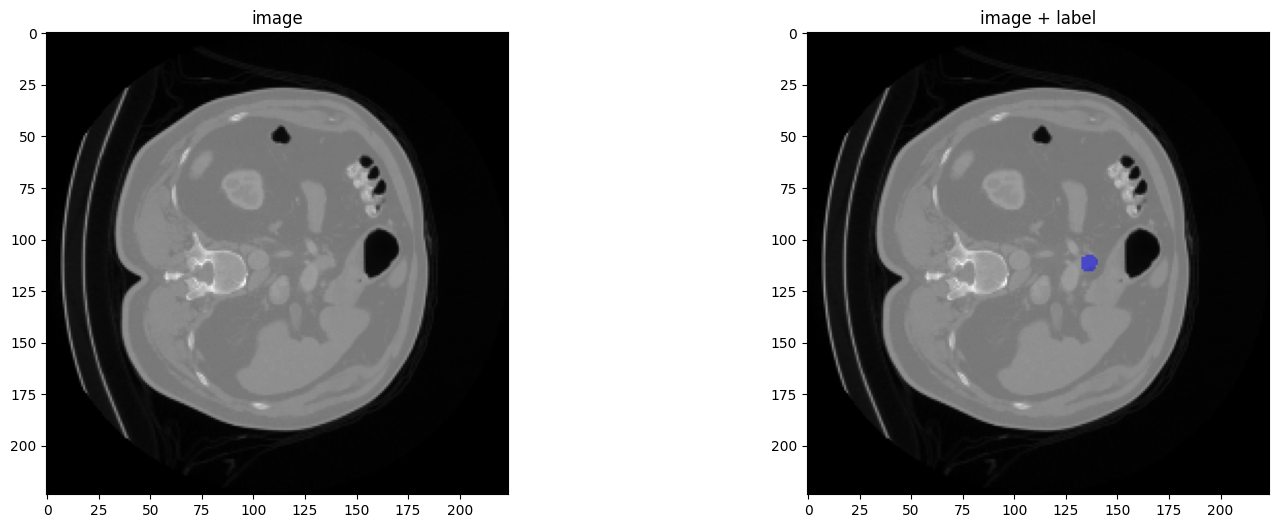

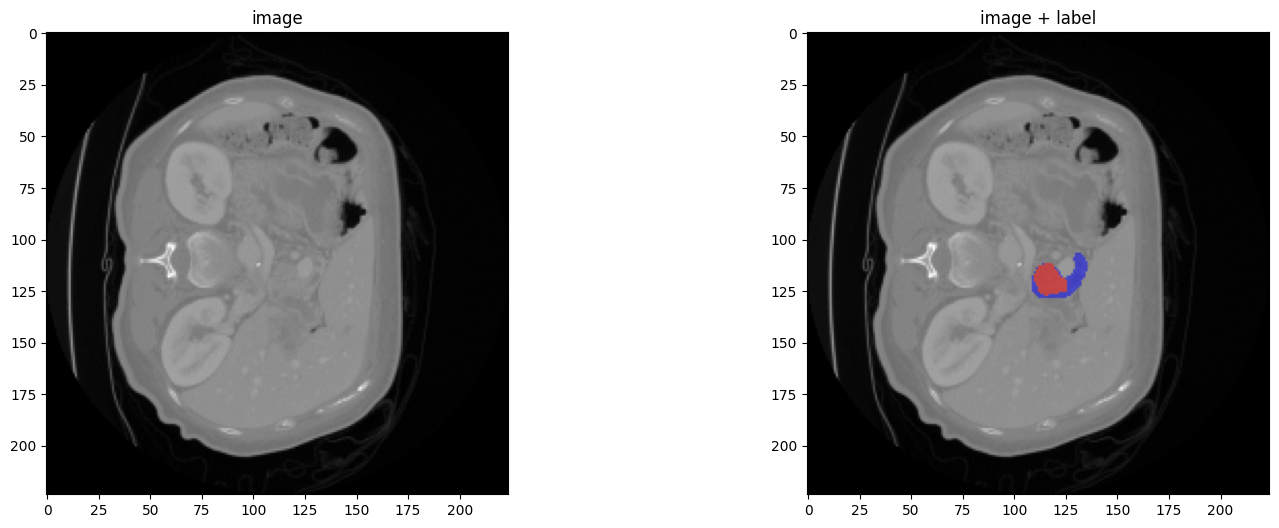

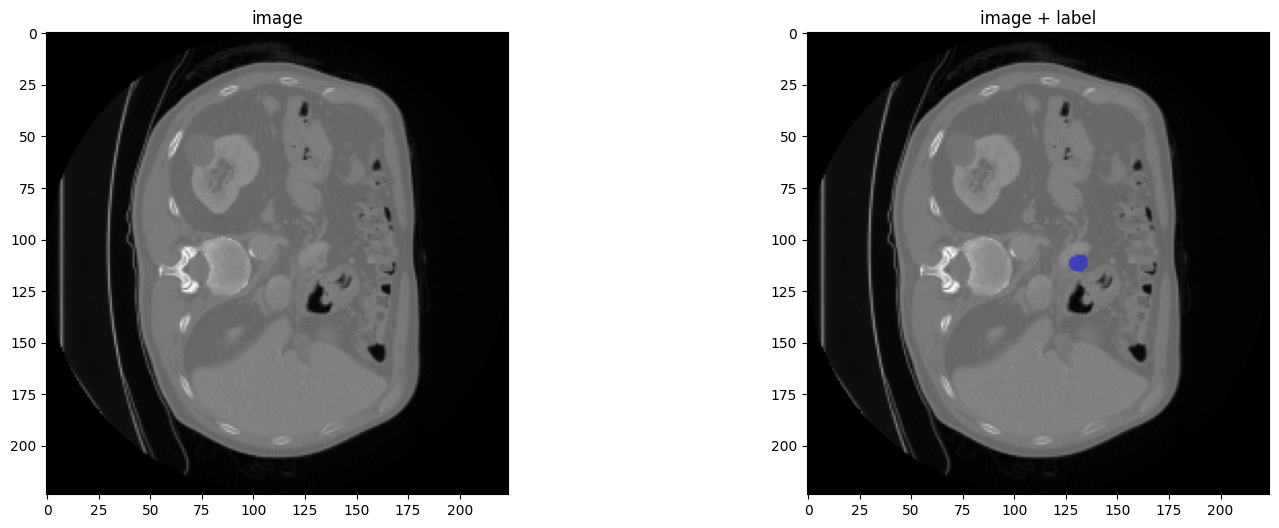

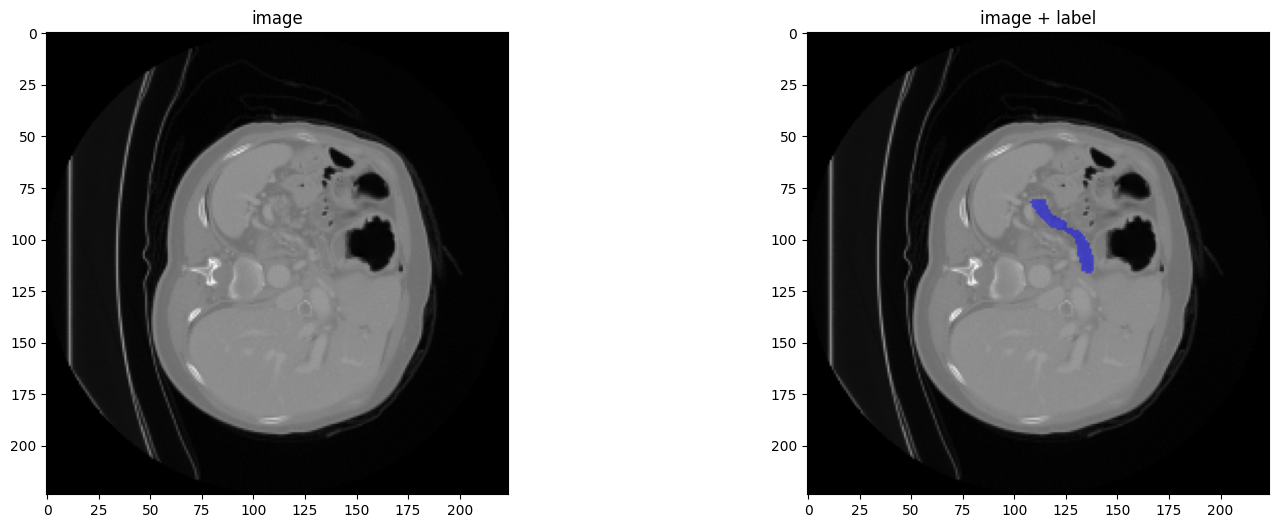

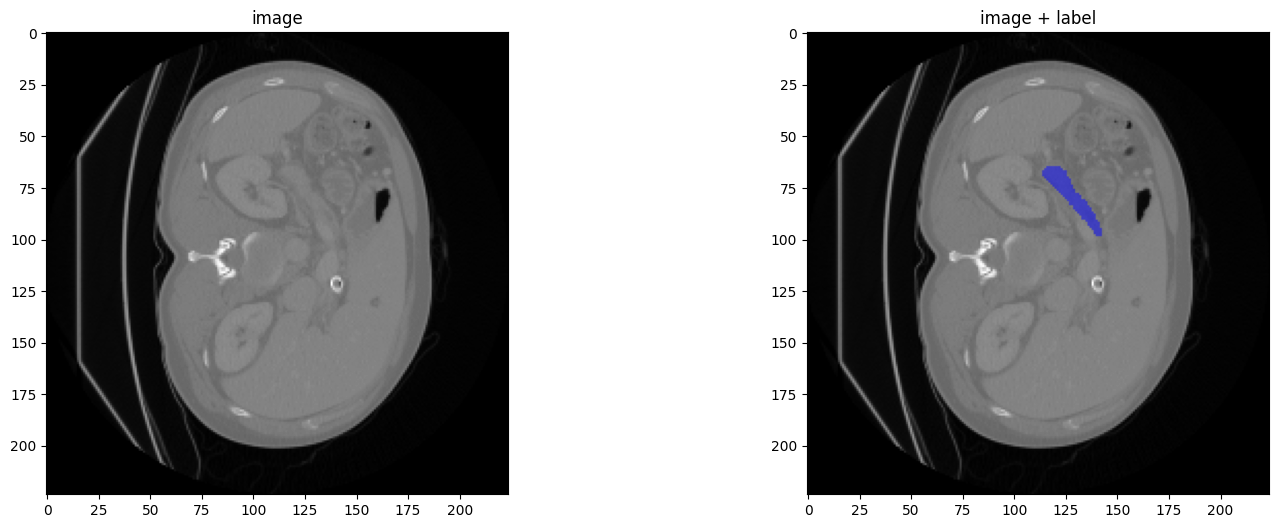

In [27]:
colors = [(0, 0, 1, i) for i in np.linspace(0, 1, 100)]
blue_cmap = mcolors.LinearSegmentedColormap.from_list('blue_alpha', colors)

colors = [(1, 0, 0, i) for i in np.linspace(0, 1, 100)]
red_cmap = mcolors.LinearSegmentedColormap.from_list('red_alpha',colors)
for i in range(4,9):                                               
    val_data_example=train_ds[i]
    # Select a slice to visualize (e.g., the middle slice)
    slice_idx = val_data_example['image'].shape[3] // 2  # adjust to the depth dimension

    # Get image and labels
    image = val_data_example['image'][0, :, :, slice_idx].detach().cpu()
    label2 = val_data_example['label'][1, :, :, slice_idx].detach().cpu()
    label3 = val_data_example['label'][2, :, :, slice_idx].detach().cpu()

    # Create a figure
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image, cmap='gray')

    # Overlay the labels
    # We're using different colors and transparency (alpha) for each label
    plt.subplot(1, 2, 2)
    plt.title("image + label")
    plt.imshow(image, cmap='gray')
    plt.imshow(label2, cmap=blue_cmap, alpha=0.5)  # Use alpha for transparency
    plt.imshow(label3, cmap=red_cmap, alpha=0.5)  # Change 'jet' to any colormap you prefer

    # plt.axis('off')  # To not show axis
    plt.show()


In [28]:

# Define your UNet model as a function
def unet(in_channels, out_channels):
    model = SegResNet(
        blocks_down=[1, 2, 2, 4],
        blocks_up=[1, 1, 1],
        init_filters=16,
        in_channels=in_channels,
        out_channels=out_channels,
        dropout_prob=0.2,
    )
    return model


In [29]:

# Define your UNet model
in_channels = 1
out_channels = 3
model = unet(in_channels, out_channels)

# Rest of the code
max_epochs = 300
val_interval = 1
VAL_AMP = True

device = torch.device("cuda:0")
model = model.to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


scaler = torch.cuda.amp.GradScaler()
torch.backends.cudnn.benchmark = True


In [30]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_class1 = [] # Adjusted class labels for clarity
metric_values_class2 = [] # Adjusted class labels for clarity
metric_values_class3 = [] # Adjusted class labels for clarity
max_epochs=30

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print('hello')
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_class1 = metric_batch[0].item() # Adjusted class labels for clarity
            metric_values_class1.append(metric_class1) # Adjusted class labels for clarity
            metric_class2 = metric_batch[1].item() # Adjusted class labels for clarity
            metric_values_class2.append(metric_class2) # Adjusted class labels for clarity
            metric_class3 = metric_batch[2].item() # Adjusted class labels for clarity
            metric_values_class3.append(metric_class3) # Adjusted class labels for clarity
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" class1: {metric_class1:.4f} class2: {metric_class2:.4f} class3: {metric_class3:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

# Calculate the mean dice score of only the 2nd and 3rd classes
mean_dice_score = (metric_values_class2[-1] + metric_values_class3[-1]) / 2.0
print(f"Mean Dice Score (class 2 and 3): {mean_dice_score:.4f}")


hello
----------
epoch 1/300
1/225, train_loss: 0.8057, step time: 0.4433
2/225, train_loss: 0.7630, step time: 0.3415
3/225, train_loss: 0.7506, step time: 0.3431
4/225, train_loss: 0.7611, step time: 0.3474
5/225, train_loss: 0.7487, step time: 0.3449
6/225, train_loss: 0.7479, step time: 0.3461
7/225, train_loss: 0.7466, step time: 0.3418
8/225, train_loss: 0.7456, step time: 0.3415
9/225, train_loss: 0.7471, step time: 0.3454
10/225, train_loss: 0.7459, step time: 0.3415
11/225, train_loss: 0.7446, step time: 0.3391
12/225, train_loss: 0.7428, step time: 0.3426
13/225, train_loss: 0.7439, step time: 0.3377
14/225, train_loss: 0.7447, step time: 0.3388
15/225, train_loss: 0.7441, step time: 0.3389
16/225, train_loss: 0.7446, step time: 0.3392
17/225, train_loss: 0.7392, step time: 0.3372
18/225, train_loss: 0.7468, step time: 0.3484
19/225, train_loss: 0.7398, step time: 0.3391
20/225, train_loss: 0.7403, step time: 0.3398
21/225, train_loss: 0.7434, step time: 0.3419
22/225, train_

In [ ]:
print('hekllo')

In [9]:
torch.cuda.empty_cache()

: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_images(image_batch, label_batch):
    # Convert torch tensors to numpy arrays
    images = image_batch.squeeze().cpu().numpy()
    labels = label_batch.squeeze().cpu().numpy()

    # Plot each image and its label
    num_images = images.shape[0]
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 10))

    for i in range(num_images):
        axes[i, 0].imshow(images[i, 0, :, :], cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Image')

        axes[i, 1].imshow(labels[i, 0, 0, :, :], cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Label')

    plt.tight_layout()
    plt.show()

# Visualize a batch of images from the train loader
for batch in train_loader:
    image_batch, label_batch = batch["image"], batch["label"]
    visualize_images(image_batch, label_batch)
    break  # Only visualize the first batch

# Visualize a batch of images from the validation loader
for batch in val_loader:
    image_batch, label_batch = batch["image"], batch["label"]
    visualize_images(image_batch, label_batch)
    break  # Only visualize the first batch


In [ ]:
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.transforms import AsDiscrete, Activations, Compose
from monai.inferers import sliding_window_inference

max_epochs = 30
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create UNet, DiceLoss, and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1, 
    out_channels=3,  
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True


In [ ]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
num_classes = 3
total_start = time.time()

# Training
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")


In [ ]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
num_classes = 3
total_start = time.time()

# Training
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # Calculate Mean Dice Score
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            dice_scores = []
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                print(val_inputs)
                print(val_inputs.shape)
                print(val_outputs)
                print(val_outputs.shape)
                val_outputs = torch.cat(val_outputs, dim=1)  # Concatenate the output channels
                val_labels_c = (val_labels.unsqueeze(1) == torch.arange(num_classes).unsqueeze(0).unsqueeze(-1).unsqueeze(-1).to(device)).float()
                val_outputs_c = val_outputs.permute(0, 2, 3, 4, 1)  # Reshape to match labels

                for c in range(num_classes):
                    val_labels_c_c = val_labels_c[:, c, ...]
                    val_outputs_c_c = val_outputs_c[:, :, :, :, c].unsqueeze(1)
                    dice_metric(y_pred=val_outputs_c_c, y=val_labels_c_c)
                    metric_c = dice_metric.aggregate().item()
                    print(f"Class {c} - Dice Score: {metric_c:.4f}")
                    dice_metric.reset()
                    dice_scores.append(metric_c)

            metric = dice_metric_batch.aggregate().item()
            metric_values.append(metric)
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            
            # Print Mean Dice Scores
            mean_dice_scores = []
            for c in range(num_classes):
                mean_dice = np.mean([dice_scores[i] for i in range(c, len(dice_scores), num_classes)])
                mean_dice_scores.append(mean_dice)
                print(f"Mean Dice Score for Class {c}: {mean_dice:.4f}")
            print(f"Mean Dice Scores: {mean_dice_scores}")

    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start
